In [1]:
from collections import defaultdict
import csv 

import pdb
import gensim
from gensim import matutils, corpora
from gensim.models.ldamodel import LdaModel
import pandas as pd
import nltk
import statsmodels 
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np
import scipy as sp
import sklearn 

import snowball

In [2]:
####
# only using tweets that contain at least one term from 
# a whitelist!
tweet_data = pd.read_csv("CancerReport-clean-whitelisted-en.txt", delimiter="\t", low_memory=False)
# pull out just the retweets
retweets = tweet_data[tweet_data["retweet"] == True]
unique_retweet_id_list = list(set(retweets["retweet_id_str"].tolist()))
# group the tweets by the tweet they are, erm, retweeting
grouped_retweets = retweets.groupby("retweet_id_str")
# then count up retweets and extract original (retweeted) text
# see code in snowball.py for doing this
orig_tweet_ids, orig_tweeter_names, orig_follower_counts, orig_tweet_texts, retweet_counts = snowball._count_up_retweets(grouped_retweets)


In [3]:
# primary tweets (non-retweets)
primary_tweets = tweet_data[tweet_data["retweet"] == False]
# exclude tweets that are already in our retweet set (i.e.,
# exclude 'primary' versions of retweeted tweets, because 
# these are already accounted for)
primary_tweets = primary_tweets[primary_tweets["tweet_id"].isin(orig_tweet_ids) == False]
# exclude the 10 or so tweets that are missing followers counts.
primary_tweets = primary_tweets[primary_tweets["followers_count"].isnull() == False]


In [4]:
# now merge tweet sets (retweeted and not)
orig_tweet_texts.extend(primary_tweets["tweet_text"].values)
# the assumption is that these have *not* been retweeted at all!
# @TODO verify?
retweet_counts.extend([0]*primary_tweets.shape[0])
orig_follower_counts.extend(primary_tweets["followers_count"])
orig_tweeter_names.extend(primary_tweets["screen_name"])
orig_tweet_ids.extend(primary_tweets["tweet_id"])

In [5]:
X_user = np.array(orig_follower_counts)/float(max(orig_follower_counts))

# z-score normalized follower counts 
# @TODO not sure if this is the *best* choice -- should also try
# simple max norm, above
#X_user = sp.stats.mstats.zscore(orig_follower_counts)

In [6]:
## 
# build text features @TODO maybe add bigrams
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=True, stop_words="english", max_features=1000, min_df=5)
X_text = vectorizer.fit_transform(orig_tweet_texts)


In [7]:
y = np.array(retweet_counts)

In [8]:
X_all  = X_text.copy().todense()
X_user = np.matrix(X_user)
X_all  = np.hstack((X_all, X_user.T))
# add an intercept
X_all = sm.add_constant(X_all)

In [9]:
X_all.shape

(12678, 1002)

In [10]:
indices_to_tokens = dict(zip(list(vectorizer.vocabulary_.values()), list(vectorizer.vocabulary_)))

In [11]:
X_all_df = pd.DataFrame(X_all)
words = [indices_to_tokens[idx] for idx in range(X_text.shape[1])]
col_names = ["intercept"]
col_names.extend(words)
col_names.append("followers")
X_all_df.columns = col_names

In [12]:
###
# just for kicks, predict *only* based on user attributes
# (i.e., number of followers).
# Note: the upshot is that this doesn't work at all, and that, surprisingly, 
#  the # of followers seems slightly negatively correlated with re-tweet 
#  counts -- though not significantly so!
user_model = sm.OLS(y, sm.add_constant(X_user.T, prepend=True))
user_only_results = user_model.fit()
print(user_only_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1106
Date:                Sun, 24 Jan 2016   Prob (F-statistic):              0.739
Time:                        16:49:07   Log-Likelihood:                -52315.
No. Observations:               12678   AIC:                         1.046e+05
Df Residuals:                   12676   BIC:                         1.046e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.7657      0.134      5.718      0.0

In [13]:
###
# ordinary least squares, assume y is a linear 
# function of predictors.
model_all = sm.OLS(y, X_all_df)
#results = model_all.fit_regularized()
results_ols = model_all.fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.522
Date:                Sun, 24 Jan 2016   Prob (F-statistic):           5.14e-22
Time:                        16:49:10   Log-Likelihood:                -51538.
No. Observations:               12678   AIC:                         1.051e+05
Df Residuals:                   11677   BIC:                         1.125e+05
Df Model:                        1000                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
intercept               

/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


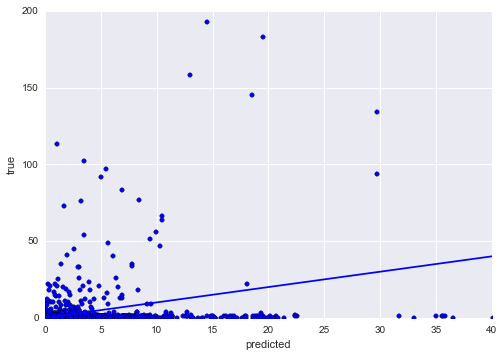

In [14]:
# scatter preds v truth
from statsmodels.graphics.api import abline_plot
yhat = results_ols.fittedvalues
fig, ax = plt.subplots()
ax.scatter(yhat.values, y)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_ylim((0,200))
ax.set_xlim((0,40))
line_fit = sm.OLS(y,sm.add_constant(yhat, prepend=True)).fit()
fitted_plot = abline_plot(model_results=line_fit, ax=ax)
#from statsmodels.graphics.api import abline_plot

In [15]:
###
# perhaps makes more since to treat as a binary classification 
# task where we try to predict whether (or not) a given tweet
# will be retweeted at least k times.
k = 5
y_bin = y >= k
y_bin = y_bin.astype(int)
model_all_bin = sm.GLM(y_bin, X_all_df, family=sm.families.Binomial())
results_bin = model_all_bin.fit()
print (results_bin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                12678
Model:                            GLM   Df Residuals:                    11677
Model Family:                Binomial   Df Model:                         1000
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 24 Jan 2016   Deviance:                       320.56
Time:                        16:50:48   Pearson chi2:                 1.58e+06
No. Iterations:                    33                                         
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
intercept                  -12.8094      1.770     -7.237      0.000       -16.278    -9.340
000       

In [16]:
results_bin.params.sort_values(ascending=False)

col              351.438475
des              219.012493
dre              111.026344
immune           109.567815
predicts         100.534234
comes             95.690678
skin              80.260464
understand        64.189114
donate            59.169462
informed          54.862217
sophieschoice     46.063904
plus              45.298831
msm               39.619682
parenthood        36.349794
aca               34.050025
additional        29.851691
crystal           26.705498
tx4vaxchoice      25.062207
toronto           23.856163
percent           23.344184
plz               22.375233
prevalence        21.756066
appointment       20.299036
prenatal          15.854124
detecting         14.752290
35                13.685331
despite           13.640832
friday            13.371163
marketing         13.196602
island            12.936759
                    ...    
blood            -96.496174
role             -96.756441
100              -97.437349
females          -97.715496
single           -99

In [17]:

###
# assess predictive performance (note that for convenience we switch 
# to sklearn here, so may be *slightly* difference but results should be
# comparable)
from sklearn import cross_validation
cv = sklearn.cross_validation.StratifiedKFold(y_bin, n_folds=5, shuffle=True)
clf = sklearn.linear_model.SGDClassifier(class_weight="auto")
aucs = cross_validation.cross_val_score(clf, X_all, y_bin, scoring="roc_auc", cv=cv)
res = sp.stats.describe(aucs)
print("mean AUC: %s; variance: %s; min, max: %s" % (res.mean, res.variance, res.minmax))

mean AUC: 0.659080232914; variance: 0.00113550302124; min, max: (0.6064664419246093, 0.69621513944223112)
